In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
# from keras.utils import multi_gpu_model

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    lo`gical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [25]:
df = pd.read_csv('data/ten_year.csv')
# df['date'] = pd.to_datetime(df['update'],format='%d/%m/%Y %H:%M:%S').dt.date
df['date'] = pd.to_datetime(df['date'])
# df = df.drop(columns='update')

In [26]:
df_pnj = df[df['type']=='PNJ']
df_sjc = df[df['type']=='SJC']

In [5]:
df.groupby('type')['sell'].describe()

count       mean        std    min    25%    50%    75%    max
type                                                                  
PNJ   12121.0  42.521313  11.021850  29.50  33.46  36.12  53.10   75.7
SJC   12119.0  46.598107  14.522336  32.32  35.63  36.67  56.55  354.3

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24240 entries, 0 to 24239
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   type    24240 non-null  object 
 1   buy     24240 non-null  float64
 2   sell    24240 non-null  float64
 3   date    24240 non-null  object 
dtypes: float64(2), object(2)
memory usage: 757.6+ KB


In [8]:
df.shape

(24240, 4)

In [27]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.duplicated().sum()

8630

In [28]:
df = df.drop_duplicates()

In [19]:
df.shape

(15610, 5)

In [6]:
df.head()

Unnamed: 0 type    buy   sell       date
0           0  SJC  36.82  36.65 2014-06-23
1           1  PNJ  34.30  34.10 2014-06-23
2           7  PNJ  34.35  34.15 2014-06-23
3           9  SJC  36.81  36.69 2014-06-23
4          10  SJC  36.84  36.72 2014-06-23

In [7]:
df.isnull().sum().sum()

0

In [29]:
df_sjc = df_sjc.drop_duplicates(subset=['date'])
df_pnj = df_pnj.drop_duplicates(subset=['date'])
df_sjc = df_sjc.drop(columns=['type'])
df_pnj = df_pnj.drop(columns=['type'])
df_sjc['date'] = pd.to_datetime(df_sjc['date'])
df_pnj['date'] = pd.to_datetime(df_pnj['date'])
df_pnj.sort_values(by='date', ascending=True, inplace=True)
df_pnj.reset_index(drop=True, inplace=True)
df_sjc.sort_values(by='date', ascending=True, inplace=True)
df_sjc.reset_index(drop=True, inplace=True)

In [30]:
df_pnj.to_csv('data/PNJ.csv',index=False)
df_sjc.to_csv('data/SJC.csv',index=False)

## Visualizing Gold Price History Data
**Interactive Gold Price Chart:**


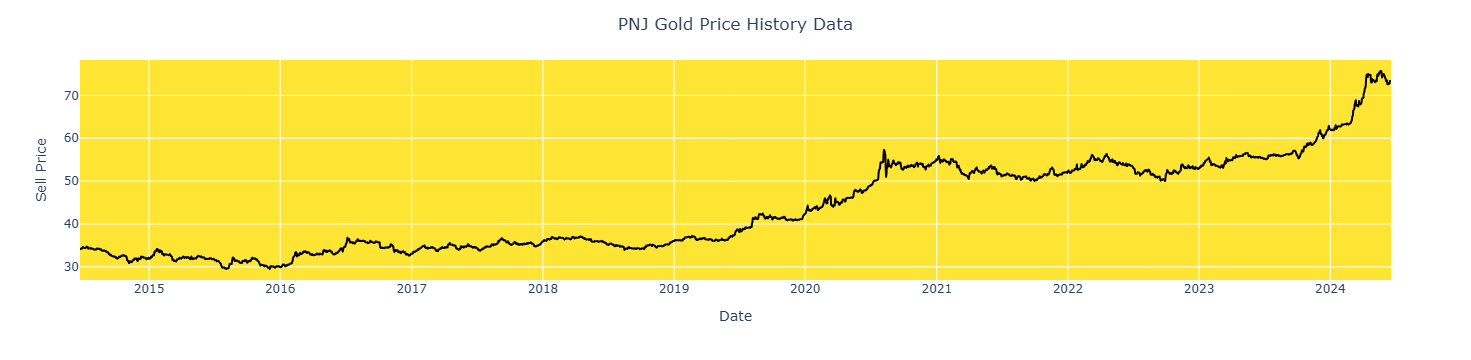

In [16]:
fig = px.line(y=df_pnj.sell, x=df_pnj.date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Sell Price",
                  title={'text': "PNJ Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

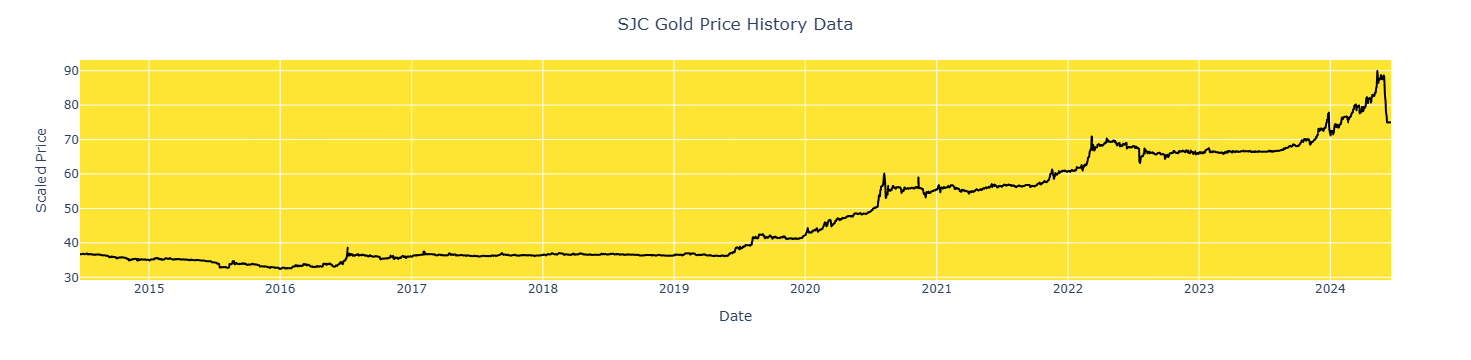

In [17]:
df_sjc = df_sjc.drop_duplicates(subset=['date'])
fig = px.line(y=df_sjc.sell, x=df_sjc.date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "SJC Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [9]:
df_pnj.to_csv('data/PNJ.csv')
df_sjc.to_csv('data/SJC.csv')

## Split dataset to train
`Note`: we can't random split time series to train, we should use data in future. In this situation, i use data from 2024.

In [18]:
df_sjc = df_sjc.drop(columns = ['type'])

In [19]:
df_sjc['date'] = pd.to_datetime(df_sjc['date'])
df_sjc.sort_values(by='date', ascending=True, inplace=True)
df_sjc.reset_index(drop=True, inplace=True)

In [20]:
test_size = df_sjc[df_sjc.date.dt.year==2024].shape[0]
test_size

136

### Gold Price Training and Test Sets Plot:

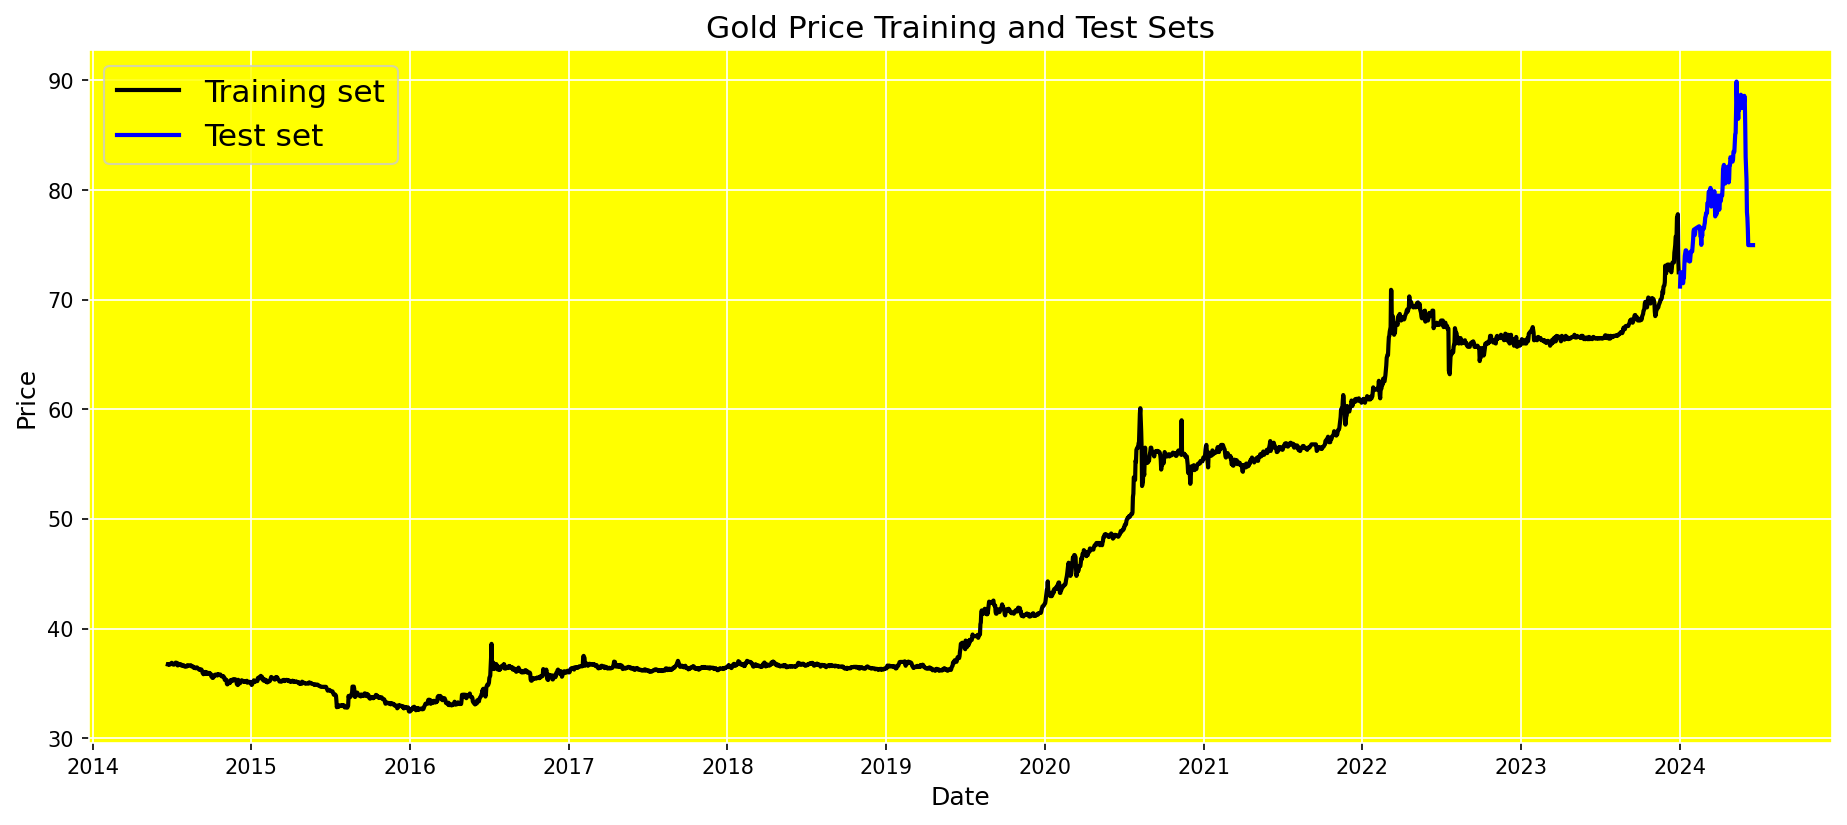

In [21]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df_sjc.date[:-test_size], df_sjc.sell[:-test_size], color='black', lw=2)
plt.plot(df_sjc.date[-test_size:], df_sjc.sell[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [22]:
scaler = MinMaxScaler()
scaler.fit(df_sjc.sell.values.reshape(-1,1))

MinMaxScaler()

In [23]:
window_size = 60

In [24]:
train_data = df_sjc.sell[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [25]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):   
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [26]:
test_data = df_sjc.sell[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [27]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [28]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [30]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2846, 60, 1)
y_train Shape:  (2846, 1)
X_test Shape:   (136, 60, 1)
y_test Shape:   (136, 1)


In [31]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [32]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
with tf.device('/device:GPU:0'):
    model = define_model()
    history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 
print(X_train)

5/5 [==============================] - 0s 15ms/step
[[[0.07480863]
  [0.07463466]
  [0.07533055]
  ...
  [0.07011134]
  [0.06958942]
  [0.06663187]]

 [[0.07463466]
  [0.07533055]
  [0.07533055]
  ...
  [0.06958942]
  [0.06663187]
  [0.06732777]]

 [[0.07533055]
  [0.07533055]
  [0.07446068]
  ...
  [0.06663187]
  [0.06732777]
  [0.06680585]]

 ...

 [[0.65379262]
  [0.65727209]
  [0.65553236]
  ...
  [0.75382742]
  [0.78427279]
  [0.78253305]]

 [[0.65727209]
  [0.65553236]
  [0.65466249]
  ...
  [0.78427279]
  [0.78253305]
  [0.789492  ]]

 [[0.65553236]
  [0.65466249]
  [0.65205289]
  ...
  [0.78253305]
  [0.789492  ]
  [0.7164231 ]]]


In [ ]:
model.save('ngumodel.h5')

In [ ]:
y_train_pred = model.predict(X_train)

89/89 [==============================] - 1s 13ms/step


In [ ]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [ ]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.037530604749917984
Test MAPE: 0.20941955073459212
Test Accuracy: 0.7905804492654078


In [ ]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)
y_train_true = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(y_train_pred)

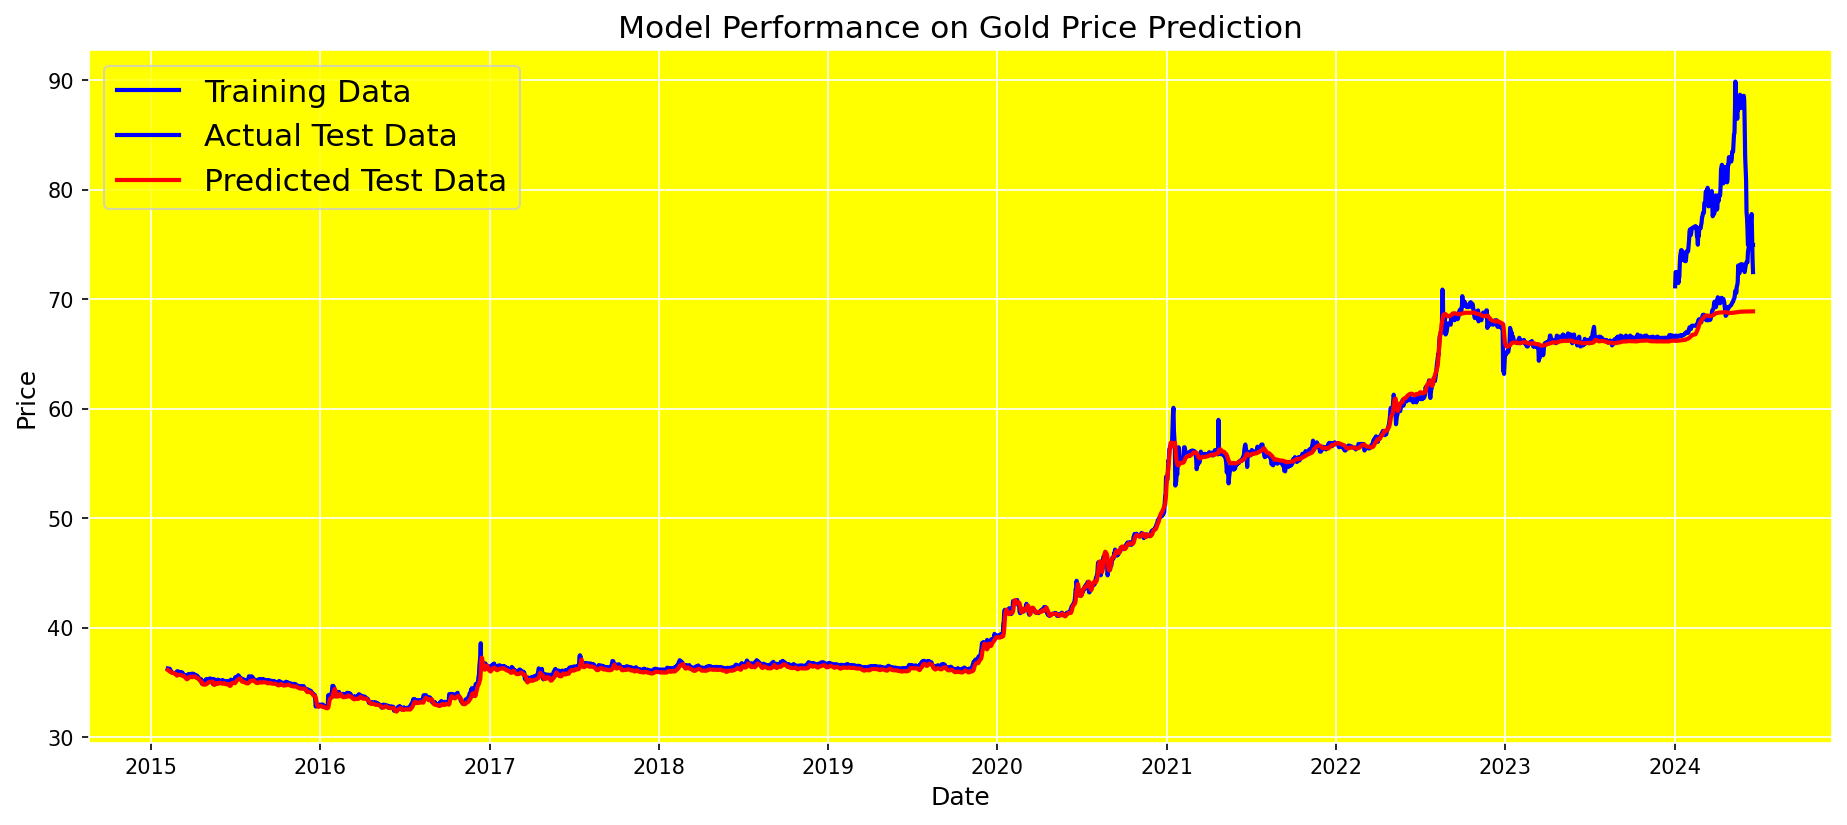

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
# plt.plot(df_sjc['date'].iloc[:df_sjc.shape[0]], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df_sjc['date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df_sjc['date'].iloc[-y_train_true.shape[0]:], y_train_true, color='blue', lw=2)
plt.plot(df_sjc['date'].iloc[-y_train_true.shape[0]:], y_train_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()